#AlexNet model with maxpooling layer after each conv layer

##Train with 1220 Data

#importing

In [ ]:
from torch.utils.data import  random_split, ConcatDataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

#Create model

In [ ]:
# Define the AlexNet model
class AlexNet(nn.Module):
    def __init__(self, num=10):
        super(AlexNet, self).__init__()
        self.feature = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=2),
            nn.Conv2d(64, 96, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
            nn.Conv2d(96, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d( kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32*9*9,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024,num),

        )

    def forward(self, x):

        x = self.feature(x)
        # print(x.shape)
        x = x.view(-1,32*9*9)
        x = self.classifier(x)
        return x

In [ ]:
model = AlexNet()

# Data set

In [ ]:
# Define dataset transformations and load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])

dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [ ]:
#Download train dataset from mnist dataset
num_samples_per_class = 122

total_samples = num_samples_per_class * 10

class_indices = dataset.targets.unique()
datasets_per_class = []
for class_index in class_indices:
    class_samples = [i for i, label in enumerate(dataset.targets) if label == class_index]
    selected_samples = class_samples[:num_samples_per_class]
    selected_dataset = torch.utils.data.Subset(dataset, selected_samples)
    datasets_per_class.append(selected_dataset)

dataset = ConcatDataset(datasets_per_class)

In [ ]:
#creat train and validatin dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True)

In [ ]:
# Define the transformations
transform = transforms.Compose([transforms.ToTensor()])

In [ ]:
# dataset = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

#Train model

In [ ]:
#choose device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model.to(device)

AlexNet(
  (feature): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(96, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequent

In [ ]:
#Definition optimal function and loss function
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
#train model
train_accs = []
val_accs = []
train_losses = []
val_losses = []

num_epochs = 400
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0


    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()


        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    val_accuracy = 100 * correct_val / total_val
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)
    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    print('Epoch [{}/{}], Loss: {:.4f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%' .format(epoch + 1, num_epochs, running_loss / len(train_loader), train_accuracy, val_accuracy))

Epoch [1/400], Loss: 2.2985, Train Accuracy: 13.42%, Validation Accuracy: 11.07%
Epoch [2/400], Loss: 1.6615, Train Accuracy: 39.24%, Validation Accuracy: 65.98%
Epoch [3/400], Loss: 0.7929, Train Accuracy: 73.26%, Validation Accuracy: 82.79%
Epoch [4/400], Loss: 0.5001, Train Accuracy: 85.04%, Validation Accuracy: 85.25%
Epoch [5/400], Loss: 0.3855, Train Accuracy: 87.50%, Validation Accuracy: 86.48%
Epoch [6/400], Loss: 0.3025, Train Accuracy: 90.78%, Validation Accuracy: 91.80%
Epoch [7/400], Loss: 0.2240, Train Accuracy: 92.73%, Validation Accuracy: 91.39%
Epoch [8/400], Loss: 0.1741, Train Accuracy: 94.77%, Validation Accuracy: 93.44%
Epoch [9/400], Loss: 0.1407, Train Accuracy: 95.70%, Validation Accuracy: 95.08%
Epoch [10/400], Loss: 0.1358, Train Accuracy: 96.41%, Validation Accuracy: 94.26%
Epoch [11/400], Loss: 0.1491, Train Accuracy: 96.00%, Validation Accuracy: 94.26%
Epoch [12/400], Loss: 0.0849, Train Accuracy: 97.54%, Validation Accuracy: 92.62%
Epoch [13/400], Loss: 0.0

In [ ]:
# Save the trained model
torch.save(model.state_dict(), '/content/drive/MyDrive/D.L/trained_model2.pth')

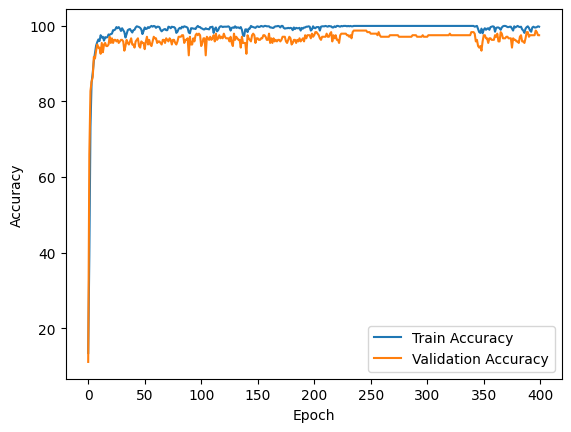

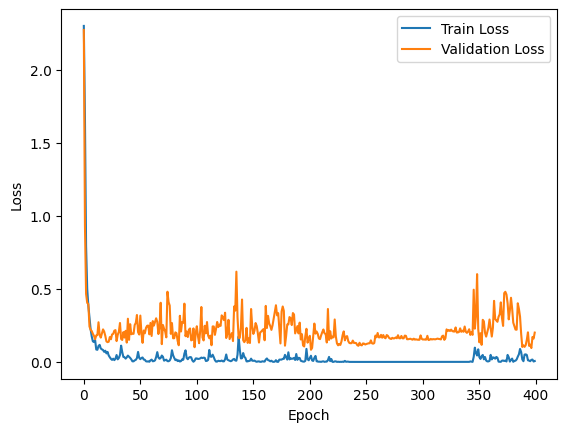

In [ ]:
#Plot Accuracy during train
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Plot Loss during train
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Evaluation

In [ ]:
# Evaluation of the model with test data
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = (correct / total)*100
print('Accuracy For Test Dataset ', accuracy)

Accuracy For Test Dataset  96.78999999999999
